In [1]:
import scipy.stats as sps
import numpy as np

В данной части мы генерируем синтетические данные, которые в дальнейшем будут использованы для проверки работы алгоритма.

In [2]:
# количество признаков
n = 30
# размер выборки
m = 100
def data_generator(n, m, cov=0.2):
    # cov - коэффициент, задающий ковариацию между значениями
    # исходная мартица ковариации (может не быть положительно определенной) 
    pred_C = (1 - cov) * np.eye(n) + cov * np.ones((n, n))
    # вектор средних значений
    mean = np.zeros((n, ))
    # новая матрица ковариации, близкая к исходной, но положительно определенная
    # и с более разнообразными собственными значениями
    C = np.cov(sps.multivariate_normal(mean, pred_C).rvs(size=m).T)
    # поделим строки и стобцы на корень из диагонали чтобы генерируемые Х имели
    # единичную дисперсию
    diag_sqrt = np.sqrt(np.diag(C))
    C = C / diag_sqrt
    C = C.T / diag_sqrt
    # генерируем выборку - она имеет нулевое матожидание и (почти) единичную 
    # дисперсию в каждом столбце
    X = sps.multivariate_normal(mean, C).rvs(size=m)
    # генерируем коэффициенты и делим их на соответствующее число, чтобы в итоге
    # дисперсия Z была равна 1
    a = sps.uniform(loc=0, scale=1).rvs(n)
    a /= (a.dot(a) * (1 - cov) + cov * (a.sum())**2)
    # генерируем предсказываемую переменную так, чтобы ее дисперсия была равна 1
    # для этого делим на соответствующий коэффициент 
    Z = X.dot(a) + sps.norm(loc=0, scale=0.1).rvs(size=m)

    return X, Z

Далее реализуем метод ForwardRegression и OMP


In [3]:
from sklearn.metrics import r2_score

def cov_score(y, y_pred, x_m):
    res = y - y_pred
    return np.abs(((res - res.mean())*(x_m - x_m.mean())).mean())

In [4]:
def ForwardRegression(X, y, model, k):
    S = []
    n = X.shape[1]
    scores = []
    while len(S) < k:
        max_score = 0
        max_index = 0
        for i in range(n):
              if i not in S:
                S.append(i)
                y_pred = model.fit(X.T[S].T, y).predict(X.T[S].T)
                S = S[: -1]
                new_score = r2_score(y, y_pred)
                if new_score > max_score:
                    max_index = i
                    max_score = new_score
        S.append(max_index)
        scores.append(max_score)
    return S, np.array(scores)

In [5]:
def OMP(X, y, model, k):
    S = []
    n = X.shape[1]
    scores = []
    while len(S) < k:
        max_score = 0
        max_index = 0
        for i in range(n):
              if i not in S:
                if len(S) != 0:
                    model.fit(X.T[S].T, y)
                    y_pred = model.predict(X.T[S].T)
                else:
                    y_pred = np.zeros(y.shape)
                new_score = cov_score(y, y_pred, X.T[i])
                S.append(i)
                model.fit(X.T[S].T, y)
                y_pred = model.predict(X.T[S].T)
                new_r2_score = r2_score(y, y_pred)
                S = S[: -1]
                if new_score > max_score:
                    max_index = i
                    max_score = new_score
                    max_r2_score = new_r2_score
        S.append(max_index)
        scores.append(max_r2_score)
    return S, np.array(scores)

In [6]:
def ObliviousAlgorithm(X, y, model, k):
    x_norm = X - X.mean(axis=0)
    y_norm = y - y.mean()
    S = np.argsort(-np.abs((y * X.T).mean(axis=1)))[:k]
    n = X.shape[1]
    scores = []
    for i in range(len(S)):
        model.fit(X.T[S[:i + 1]].T, y)
        y_pred = model.predict(X.T[S[:i + 1]].T)
        scores.append(r2_score(y, y_pred))
    return S, np.array(scores)

In [7]:
from itertools import combinations
#для одного k
def opt(X, y, model, k):
    n = X.shape[1]
    indexes = [i for i in range(n)]
    max_score = 0
    max_subset = []
    for subset in combinations(indexes, k):
        subset = list(subset)
        if k > 1:
            model.fit(X.T[subset].T, y)
            y_pred = model.predict(X.T[subset].T)
        else:
            model.fit(X.T[subset].T.reshape(X.shape[0], 1), y)
            y_pred = model.predict(X.T[subset].T.reshape(X.shape[0], 1))
        new_score = r2_score(y, y_pred)
        if new_score > max_score:
            max_score = new_score
            max_subset = subset
    return max_subset, max_score

In [8]:
#для k и всех до него
def OPT(X, y, model, k):
    S = [list()] * k
    scores = [0] * k
    for n in range(1, k + 1):
        S[n-1], scores[n-1] = opt(X, y, model, n)
    return S, scores

In [9]:
from sklearn.linear_model import Lasso
#для одного k
def l1(X, y, model, k, alpha, eps, max_iter):
    n = X.shape[1]
    for i in range(max_iter):
        lasso = Lasso(alpha=alpha)
        lasso.fit(X, y)
        if (np.abs(lasso.coef_) < eps).sum() >= n-k:
            break
        alpha *= 1.1
    result = np.argsort(lasso.coef_)[-k:]
    model.fit(X.T[result].T, y)
    score = r2_score(y, model.predict(X.T[result].T))
    return result, score

In [10]:
# для k и всех до него
def L1(X, y, model, k, alpha=1e-4, eps=1e-3, max_iter=1000):
    S = [list()] * k
    scores = [0] * k
    for n in range(1, k + 1):
        S[n-1], scores[n-1] = l1(X, y, model, n, alpha, eps, max_iter)
    return S, np.array(scores)

In [11]:
methods = {
    'Forward Regression': ForwardRegression,
    'OMP': OMP,
    'Oblivious Algorithm': ObliviousAlgorithm,
    'OPT': OPT,
    'L1': L1
}

In [12]:
from sklearn.linear_model import LinearRegression
from tqdm import trange

times = 10
n = 30
m = 100
k_max = 15
result = {}
for key in methods.keys():
    result[key] = np.zeros((k_max, ))
forbidden = ['OPT'] 
regression = LinearRegression()
for i in trange(times):
    x, z = data_generator(n, m)
    for key in methods.keys():
        if key not in forbidden:
            _, scores = methods[key](x, z, regression, k_max)
            result[key] += scores
for key in result.keys():
    result[key] /= times 

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


In [13]:
from matplotlib import pyplot as plt
def make_plot(result, forbidden, name):
    plt.figure(figsize=(15, 8))
    K = range(2, k_max + 1)

    for key in result.keys():
        if key not in forbidden:
            plt.plot(K, result[key][1:], label=key)

    plt.xlim((min(K), max(K)))
    plt.xlabel('k', fontsize=25)
    plt.ylabel(r'$R^2$', fontsize=25)
    plt.legend(fontsize=16)
    plt.xticks(K, fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid()
    plt.savefig(name)
    plt.show()

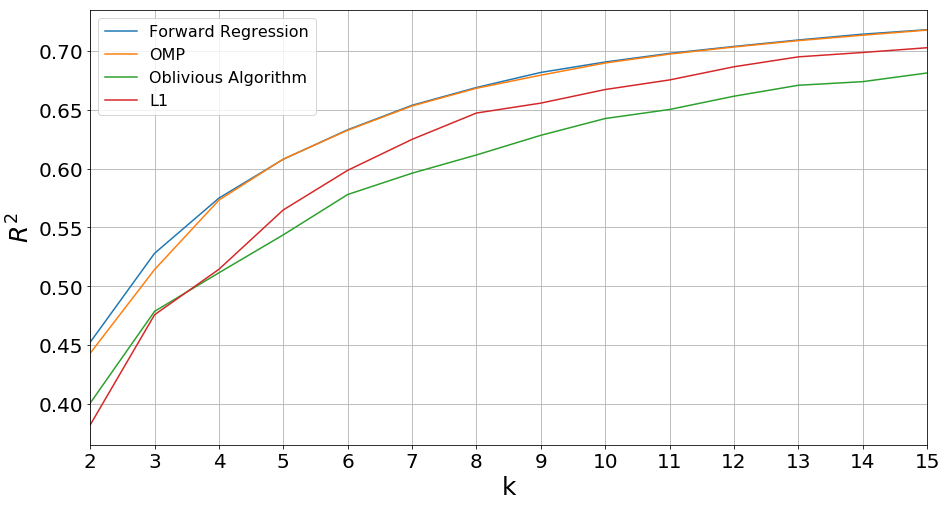

In [14]:
make_plot(result, forbidden, 'sythetic_data.png')

In [15]:
from sklearn.datasets import load_boston
import pandas as pd
boston_dataset = load_boston()

In [16]:
X = np.array(pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names))
y = boston_dataset.target

In [17]:
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_norm = x_scaler.fit_transform(X)
y_norm = y_scaler.fit_transform(y[:, np.newaxis]).squeeze()

In [18]:
k_max = X.shape[1] * 2 / 3
regression = LinearRegression()
forbidden = []
result = {}
for key in methods.keys():
    if key not in forbidden:
        S, scores = methods[key](X_norm, y_norm, regression, k_max)
        result[key] = scores

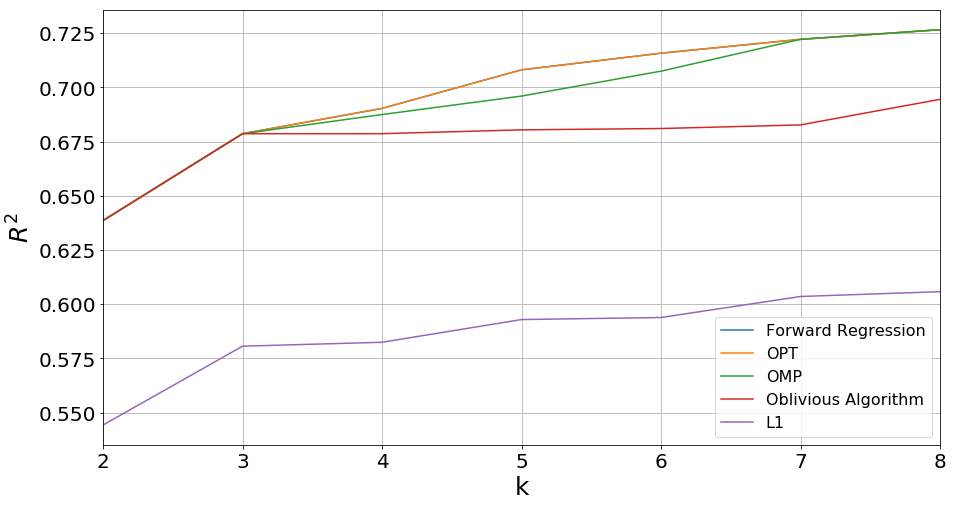

In [19]:
make_plot(result, forbidden, 'boston_housing.png')